In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import itertools
import gc
import datetime as dt

from dateutil import tz

import re
import math
from scipy import stats

import urllib.request
from PIL import Image, ImageEnhance, ImageFilter

import pytesseract
from pytesseract import image_to_string

from skimage import data, io, filters

from PIL import Image

start=dt.datetime.now()
pd.set_option('display.max_columns', None)

cwd = os.getcwd()
data_dir=cwd+'/data/'
player_data_file='C:\\Users\\bill_\\Fantasy_Football_2019\\FFootball_Data_Gathering_p2_7\\player_data_C_2019.csv'

pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

data_dir=os.getcwd()+'\\data\\'
print('Data Directory= {}'.format(data_dir))

print('Initializations done.')


Data Directory= C:\Users\bill_\Fantasy_Football_2019\Fan_Duel\data\
Initializations done.


In [2]:
week=input("What week are we working on? ")
week_input=week

weekly_file="fd_week_"+week+".csv"
print("Calculating lineup based on this file: {}".format(data_dir+weekly_file))
qb_min_sal=int(input("Minimum QB Salary? "))
defense_team=input("Which Team on Defense? ")
defense_salary=int(input('{} salary: '.format(defense_team)))
max_tier=int(input("Worst player tier? (7=B- 8=C 9=C- etc.) "))
best_defense=int(input("Best defense to face (Toughest=1 Weakest=32): "))

What week are we working on? 16
Calculating lineup based on this file: C:\Users\bill_\Fantasy_Football_2019\Fan_Duel\data\fd_week_16.csv
Minimum QB Salary? 7100
Which Team on Defense? Pittsburgh
Pittsburgh salary: 4900
Worst player tier? (7=B- 8=C 9=C- etc.) 9
Best defense to face (Toughest=1 Weakest=32): 4


In [38]:
#weekly_file="fd_week_"+str(week)+"_sat.csv"
#best_defense=3

##  Make Defensive Rankings and Dicts

In [3]:
#all_players_loc="C:\\Users\\bill_\\Fantasy_Football_2019\\FFootball_Data_Gathering_p2_7\\"
all_players=pd.read_csv(player_data_file,index_col=0).reset_index(drop=True)
#print(all_players.tail(2))

def get_opponent(team,home,away):
    if team==home:
        return away
    elif team==away:
        return home
    else:
        return 'Problem'
    
def get_uniques():
    print('Unique players: {}, Unique games: {} Unique years: {} Unique weeks: {}'.format(len(all_players['id'].unique()),
                                len(all_players.eid.unique()),len(all_players.year.unique()),
                                len(all_players.week.unique())))
    return
    
    
all_players=all_players.loc[all_players.year==2019,:]
week=int(week_input)
all_players=all_players.loc[(all_players.year==2019)&(all_players.week<int(week)),:]
all_players=all_players.fillna(0)
#print('\n\nB\n',all_players.tail(2))
all_players=all_players.rename(columns={'home_y':'home','home_x':'at_home'})
all_players['opp']=all_players.apply(lambda x: get_opponent(x.team,x.home,x.away),axis=1)
all_players=all_players.drop('Unnamed: 0.1',axis=1)
get_uniques()
all_players.tail(1)


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (104) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Unique players: 1555, Unique games: 224 Unique years: 1 Unique weeks: 15


,a_first_downs,a_passing_yds,a_penalty_cnt,a_penalty_yds,a_pos_time_tot_seconds,a_punt_avg,a_punt_cnt,a_punt_yds,a_rushing_yds,a_total_yds,a_turnovers,away,birthdate,day,defense_ast,defense_ffum,defense_fgblk,defense_frec,defense_frec_tds,defense_frec_yds,defense_int,defense_int_tds,defense_int_yds,defense_misc_tds,defense_misc_yds,defense_pass_def,defense_puntblk,defense_qbhit,defense_safe,defense_sk,defense_sk_yds,defense_tds,defense_tkl,defense_tkl_loss,defense_tkl_loss_yds,defense_tkl_primary,defense_xpblk,eid,first_down,first_name,fourth_down_att,fourth_down_conv,fourth_down_failed,fumbles_forced,fumbles_lost,fumbles_notforced,fumbles_oob,fumbles_rcv,fumbles_rec,fumbles_rec_tds,fumbles_rec_yds,fumbles_tot,fumbles_trcv,fumbles_yds,gamekey,h_first_downs,h_passing_yds,h_penalty_cnt,h_penalty_yds,h_pos_time_tot_seconds,h_punt_avg,h_punt_cnt,h_punt_yds,h_rushing_yds,h_total_yds,h_turnovers,height,at_home,home,id,kicking_all_yds,kicking_downed,kicking_fga,kicking_fgb,kicking_fgm,kicking_fgm_yds,kicking_fgmissed,kicking_fgmissed_yds,kicking_fgyds,kicking_i20,kicking_rec,kicking_rec_tds,kicking_tot,kicking_totpfg,kicking_touchback,kicking_xpa,kicking_xpb,kicking_xpmade,kicking_xpmissed,kicking_xptot,kicking_yds,kickret_avg,kickret_fair,kickret_lng,kickret_lngtd,kickret_oob,kickret_ret,kickret_tds,kickret_touchback,kickret_yds,last_name,loser,meridiem,month,name,passing_att,passing_cmp,passing_cmp_air_yds,passing_first_down,passing_incmp,passing_incmp_air_yds,passing_int,passing_ints,passing_sk,passing_sk_yds,passing_tds,passing_twopta,passing_twoptm,passing_twoptmissed,passing_yds,penalty,penalty_first_down,penalty_yds,playerid,pos,position,profile_id,punting_avg,punting_blk,punting_i20,punting_lng,punting_pts,punting_tot,punting_touchback,punting_yds,puntret_avg,puntret_downed,puntret_fair,puntret_lng,puntret_lngtd,puntret_oob,puntret_ret,puntret_tds,puntret_tot,puntret_touchback,puntret_yds,receiving_lng,receiving_lngtd,receiving_rec,receiving_tar,receiving_tds,receiving_twopta,receiving_twoptm,receiving_twoptmissed,receiving_yac_yds,receiving_yds,rushing_att,rushing_first_down,rushing_lng,rushing_lngtd,rushing_loss,rushing_tds,rushing_twopta,rushing_twoptm,rushing_twoptmissed,rushing_yds,score_away,score_away_q1,score_away_q2,score_away_q3,score_away_q4,score_away_q5,score_home,score_home_q1,score_home_q2,score_home_q3,score_home_q4,score_home_q5,scores,season_type,team,third_down_att,third_down_conv,third_down_failed,time,timeout,wday,week,weight,winner,xp_aborted,year,years_pro,opp
152301,16,159,7,49,1418,32,6,222,46,205,0,IND,9/8/1990,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2019121600,0.0,Pierre,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58123,27,307,6,52,2182,44,2,87,117,424,0,73.0,no,NO,00-0031331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Desir,IND,PM,12,P.Desir,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00-0031331,CB,CB,2543811.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,0,0,0,7,0,34,3,17,14,0,0,[u'NO - Q1 - FG - W.Lutz 33 yd. Field Goal Dri...,REG,IND,0.0,0.0,0.0,8:15,0.0,Mon,15,192.0,NO,0.0,2019,6.0,NO


## Add Fantasy Points appropriate for league (default Greg Fanduel)

In [4]:
def greg_fp(x):
    fp=x.passing_tds*4+x.rushing_tds*6+x.receiving_tds*6+\
        x.passing_yds/25.+x.rushing_yds/10.+x.receiving_yds/10.+\
            x.receiving_rec*0.5-2*x.fumbles_lost-x.passing_ints
    return fp

def guillotine_fp(x):
    fp=x.passing_tds*4+x.rushing_tds*6+x.receiving_tds*6+\
        x.passing_yds/25.+x.rushing_yds/10.+x.receiving_yds/10.+x.receiving_rec
    return fp


league_fp_dict={'Greg':greg_fp,'Guillotine':guillotine_fp}


# Default to Greg
all_players['FP']=all_players.apply(lambda x: league_fp_dict['Greg'](x),axis=1)

## Calculate Defensive ranks

In [5]:
max_complete_week=pd.DataFrame(all_players.groupby('week')['eid'].unique().apply(len)).reset_index(drop=False)
max_complete_week=max_complete_week.loc[max_complete_week.eid>=13,'week'].max()
max_complete_week

window=3
latest_weeks=all_players.loc[all_players.week.between(max_complete_week-window,max_complete_week),'week']
latest_weeks=list(latest_weeks.unique())
latest_weeks

[12, 13, 14, 15]

In [6]:
def calc_def_strength(pos):
    df=all_players.loc[(all_players.week.isin(list(latest_weeks)))&(all_players.position==pos),:]
    df=df.pivot_table(index='opp',columns='week', values='FP',aggfunc='sum').T.mean().sort_values()
    df=df.reset_index(drop=False).rename(columns={0:"ppg"})
    mean_team_points=df.ppg.mean()
    df['opportunity']=(df.ppg/mean_team_points).round(3)
    df['ranker']=df.ppg.rank()
    return df

def make_pos_dict(rank_df):
    pos_dict={}
    for o in rank_df.opp:
        pos_dict[o]=rank_df.loc[rank_df.opp==o,'ranker'].values[0]
    return pos_dict

qb_opp_ranks=calc_def_strength('QB')
rb_opp_ranks=calc_def_strength('RB')
te_opp_ranks=calc_def_strength('TE')
wr_opp_ranks=calc_def_strength('WR')

qb_dict=make_pos_dict(qb_opp_ranks)
rb_dict=make_pos_dict(rb_opp_ranks)
te_dict=make_pos_dict(te_opp_ranks)
wr_dict=make_pos_dict(wr_opp_ranks)

def_str={'QB':qb_dict,'RB':rb_dict,'TE':te_dict,'WR':wr_dict}
def_str['TE']['DAL']

13.0

## Read Fantasy Pros

In [7]:
def get_image(URL):

    with urllib.request.urlopen(URL) as url:
        with open('temp.jpg', 'wb') as f:
            f.write(url.read())

    img = Image.open('temp.jpg')
    return img

def convert_png_big_string_csv(web_image_address,scale_f=3.85,contrast=1.55,sharpness=2.55):
    '''scale, contrast, sharpness defaults set based on original 43x work.
    png_file expects full pathname'''
    
    screen_shot=get_image(web_image_address)
    
    width,height=screen_shot.size
    width=int(width*scale_f)
    height=int(height*scale_f)
                
    screen_shot = screen_shot.resize((width, height), Image.BILINEAR)
    screen_shot = ImageEnhance.Color(screen_shot).enhance(0.0)
    screen_shot = ImageEnhance.Contrast(screen_shot).enhance(contrast)
    screen_shot = ImageEnhance.Sharpness(screen_shot).enhance(sharpness)
    
    #plt.imshow(screen_shot)
    #plt.show()
    
    
    str1=image_to_string(screen_shot)
    return screen_shot,str1

def convert_image_string_csv(da_image,scale_f=3.85,contrast=1.55,sharpness=2.55):
    '''scale, contrast, sharpness defaults set based on original 43x work.
    png_file expects full pathname'''
    
    #screen_shot=get_image(web_image_address)
    screen_shot=da_image
    width,height=screen_shot.size
    width=int(width*scale_f)
    height=int(height*scale_f)
                
    screen_shot = screen_shot.resize((width, height), Image.BILINEAR)
    screen_shot = ImageEnhance.Color(screen_shot).enhance(0.0)
    screen_shot = ImageEnhance.Contrast(screen_shot).enhance(contrast)
    screen_shot = ImageEnhance.Sharpness(screen_shot).enhance(sharpness)
    
    #plt.imshow(screen_shot)
    #plt.show()
    
    
    str1=image_to_string(screen_shot)
    return screen_shot,str1

def adj_image(x,blue_adjustment=10,green_adjustment=0,red_adjustment=0):
    #im = Image.open(x)
    im=x
 
    data = np.array(im)   # "data" is a height x width x 4 numpy array
    red, green, blue, alpha = data.T # Temporarily unpack the bands for readability
 
        # Replace light blue with white... (leaves alpha values alone...)
    screen=225
    shade_areas = (red >=screen-red_adjustment) | (blue >= screen-blue_adjustment) | (green ==screen-green_adjustment)
    data[..., :-1][shade_areas.T] = (255, 255, 255) # Transpose back needed
 
    return Image.fromarray(data)

def get_grades(img,blue_adjustment=75):
    
    my_test=get_image(img)
    #my_test=Image.open(img)
    plt.imshow(my_test)
    plt.show()

    quality=[]
    flag1=False
    flag2=False
    i=20

    while i<200:
        my_test=adj_image(my_test,blue_adjustment=i)
        table_pic,pic_str=convert_image_string_csv(my_test,scale_f=5,contrast=1.5,sharpness=3)
        pic_list=[x for x in pic_str.split('\n') if x!='' ]
        
        try:
            player_indy=pic_list.index('Start or Sit?')
            flag1=True
        except:
            flag1=False
        
        try:
            grade_search=[x for x in pic_list if x.find('Grade')>=0]
            grades_indy=pic_list.index(grade_search[0])
            flag2=True
            
        except:
            flag2=False
            
        if flag1 and flag2:
            i=205
        else:
            flag1=False
            flag2=False
            i+=5
        
    players=pic_list[1:player_indy]
    grades=pic_list[player_indy+1:grades_indy]

    df=pd.DataFrame(columns=['Player','Grade','Comment'])
    df['Player']=players

    def do_grades(x,thing):

        if len(x.split(','))==2:
            tmp=x.split(',')
        elif len(x.split('.'))==2:
            tmp=x.split('.')
        else:
            tmp=[np.nan,np.nan]
        if thing=='Grade':
            return tmp[0]
        else:
            return tmp[1]

    df['Grade']=[do_grades(x,'Grade') for x in grades]
    df['Comment']=[do_grades(x,'Comment') for x in grades]
    return df



print('Loads done')

Loads done


In [8]:
print('C:\\Users\\bill_\\Fantasy_Football_2019\\Fan_Duel\\data\\'+'player_grades'+str(week_input)+'.csv')

C:\Users\bill_\Fantasy_Football_2019\Fan_Duel\data\player_grades16.csv


https://cdn.fantasypros.com/wp-content/uploads/16RBa.png16.png


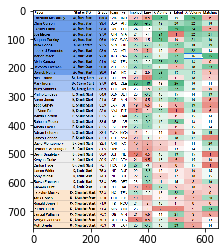

https://cdn.fantasypros.com/wp-content/uploads/16RBa.png
                Player Grade      Comment
0  Christian McCaffrey    A+   Must Start
1         Chris Carson    A+   Must Start
https://cdn.fantasypros.com/wp-content/uploads/16QB.png16.png


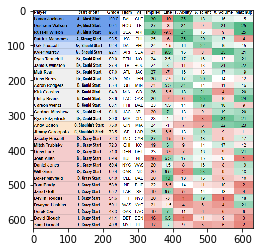

https://cdn.fantasypros.com/wp-content/uploads/16QB.png
           Player Grade      Comment
0   Lamar Jackson    A+   Must Start
1  Deshaun Watson    A+   Must Start
https://cdn.fantasypros.com/wp-content/uploads/16WR.png16.png


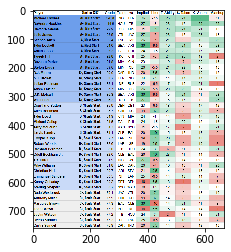

https://cdn.fantasypros.com/wp-content/uploads/16WR.png
            Player Grade      Comment
0   Michael Thomas    A+   Must Start
1  DeAndre Hopkins    A+   Must Start
https://cdn.fantasypros.com/wp-content/uploads/16TE.png16.png


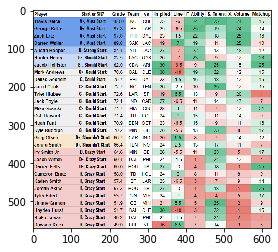

https://cdn.fantasypros.com/wp-content/uploads/16TE.png
          Player Grade      Comment
0   Travis Kelce    A+   Must Start
1  George Kittle    A+   Must Start


,Player,Grade,Comment,Tier
0,Christian McCaffrey,A+,Must Start,1.0
1,Chris Carson,A+,Must Start,1.0


In [9]:
positions=['rb','qb','wr','te']
positions=['https://cdn.fantasypros.com/wp-content/uploads/16RBa.png',
          'https://cdn.fantasypros.com/wp-content/uploads/16QB.png',
          'https://cdn.fantasypros.com/wp-content/uploads/16WR.png',
          'https://cdn.fantasypros.com/wp-content/uploads/16TE.png']

player_grades=pd.DataFrame()

for p in positions:
    print(p+str(week_input)+'.png')
    #grades=get_grades(p+str(week_input)+'.png',blue_adjustment=105)
    grades=get_grades(p,blue_adjustment=105)
    print(p)
    print(grades.head(2))
    player_grades=player_grades.append(grades)
    
tier_df=pd.DataFrame(columns=['Grade','Tier'],data=[['A+',1],['A',2],['A-',3],
                ['B+',4],['B',5],['B-',6],['C+',7],['C',8],['C-',9],
                ['D+',10],['D',11],['D-',12],['F',13]])


player_grades=pd.merge(player_grades,tier_df,how='left',on='Grade')

player_grades.to_csv('C:\\Users\\bill_\\Fantasy_Football_2019\\Fan_Duel\\data\\'+'player_grades'+str(week_input)+'.csv')
player_grades_backup=player_grades.copy()
player_grades.head(2)


In [10]:
if weekly_file in os.listdir(data_dir):
    print('Found {}'.format(weekly_file))
else:
    print('No {} found.'.format(weekly_file))

Found fd_week_16.csv


## Prep Player File from FanDuel

In [11]:
players=pd.read_csv(data_dir+weekly_file)
players=players.rename(columns={"Injury Indicator":"injury_indicator","Injury Details":"injury_details",
                               "First Name":"first_name","Last Name":"last_name"})
try:
    players.drop('Tier',inplace=True)
except:
    pass

players.head(2)

,Id,Position,first_name,Nickname,last_name,FPPG,Played,Salary,Game,Team,Opponent,injury_indicator,injury_details
0,41737-55050,RB,Christian,Christian McCaffrey,McCaffrey,26.364286,14,10800,CAR@IND,CAR,IND,NaN,NaN
1,41737-63115,QB,Lamar,Lamar Jackson,Jackson,27.989999,14,9300,BAL@CLE,BAL,CLE,NaN,NaN


In [12]:
player_grades_backup.head(3)

,Player,Grade,Comment,Tier
0,Christian McCaffrey,A+,Must Start,1.0
1,Chris Carson,A+,Must Start,1.0
2,Ezekiel Elliott,A+,Must Start,1.0


In [13]:
## Name Check

player_grades=player_grades_backup.copy() #debig only

corrections={'D.J. Chark':'DJ Chark Jr.','D.J. Moore':'DJ Moore','Devante Parker':'DeVante Parker',
                 'Dwayne Haskins':'Dwayne Haskins Jr.','D.K. Metcalf':'DK Metcalf','Marvin Jones':'Marvin Jones Jr.',
                'Todd Gurley':'Todd Gurley II','Mitch Trubisky':'Mitchell Trubisky','Leonard Fourmette':'Leonard Fournette',
                 'Allen Robinson':'Allen Robinson II','Mark Ingram':'Mark Ingram II','Ronald Jones Il':'Ronald Jones II',
                    'Leonard Foumette':'Leonard Fournette','Melvin Gordon':'Melvin Gordon III','Q.J. Howard':'O.J. Howard',
                'lan Thomas':'Ian Thomas','Gardner Minshew':'Gardner Minshew II','Marion Mack':'Marlon Mack',
            'Will Fuller':'Will Fuller V'}

for k in corrections.keys():
    player_grades.loc[player_grades.Player==k,'Player']=corrections[k]

differences=list(set(player_grades.Player).difference(set(players.Nickname)))
for d in differences:
    tmp=d.split(' ')[-1]
    print(d,players.loc[players.Nickname.str.contains(tmp),'Nickname'].values)

Darren Fells []
Todd Gurley II ['Allen Robinson II' 'Mark Ingram II' 'Melvin Gordon III'
 'Gardner Minshew II' 'Robert Griffin III' 'John Ross III'
 'Bennie Fowler III' 'Bruce Anderson III']
Deshaun Watson []
Julian Edelman []
Emmanuel Sanders ['Miles Sanders']
Justin Watson []
Jimmy Garoppolo []
Will Fuller V ["Le'Veon Bell" 'DeVante Parker' 'Vance McDonald' 'Vyncint Smith'
 'Willie Snead IV' 'Marquez Valdes-Scantling' 'Ventell Bryant'
 'Vernon Davis' 'Danny Vitale' 'Valentine Holmes' 'Seth DeValve'
 'Minnesota Vikings' 'Virgil Green' 'Nick Vannett']
George Kittle []
Matt Breida []
Devin Singletary []
Deebo Samuel ['Curtis Samuel' 'Jaylen Samuels']
Jameis Winston []
Dawson Knox []
Cameron Brate []
John Brown ['A.J. Brown' 'Jake Browning' 'Marquise Brown' 'Daniel Brown'
 'Jaron Brown' 'Fred Brown' 'Pharaoh Brown' 'Cleveland Browns']
Tyler Higbee []
O.J. Howard ['Jordan Howard']
DeAndre Hopkins []
Raheem Mostert []
Tom Brady []
James White ['JJ Arcega-Whiteside' 'DeAndrew White' 'Reggie

In [14]:
def_str['QB'].keys()

dict_keys(['BAL', 'KC', 'CIN', 'PIT', 'MIN', 'LAC', 'BUF', 'TB', 'NE', 'GB', 'SEA', 'CLE', 'CHI', 'TEN', 'NYJ', 'CAR', 'PHI', 'WAS', 'ARI', 'DET', 'NO', 'LA', 'MIA', 'DAL', 'ATL', 'HOU', 'NYG', 'DEN', 'JAX', 'SF', 'OAK', 'IND'])

In [15]:
players=players.loc[players.injury_indicator.isna()==True,:]

player_grades.rename(columns={'Player':'Nickname'},inplace=True)
players=pd.merge(players,player_grades[['Nickname','Grade','Tier']],how='left',on='Nickname')
players.loc[players.Grade.isna()==True,'Grade']='F'

players=players.loc[players.injury_indicator.isna()==True,:]

players.rename(columns={'Player':'Nickname'},inplace=True)
players=players.loc[players.Tier<=max_tier,:]

def get_opp_rank(pos,opp):
    try:
        return def_str[pos][opp]
    except:
        if opp=='LAR':
            return def_str[pos]['LA']
        if opp=='JAC':
            return def_str[pos]['JAX']

players['Opp_Rank']=players.apply(lambda x: get_opp_rank(x.Position,x.Opponent),axis=1)

players

,Id,Position,first_name,Nickname,last_name,FPPG,Played,Salary,Game,Team,Opponent,injury_indicator,injury_details,Grade,Tier,Opp_Rank
0,41737-55050,RB,Christian,Christian McCaffrey,McCaffrey,26.364286,14,10800,CAR@IND,CAR,IND,NaN,NaN,A+,1.0,17.0
1,41737-63115,QB,Lamar,Lamar Jackson,Jackson,27.989999,14,9300,BAL@CLE,BAL,CLE,NaN,NaN,A+,1.0,12.0
2,41737-28573,WR,Michael,Michael Thomas,Thomas,19.199999,14,9000,NO@TEN,NO,TEN,NaN,NaN,A+,1.0,17.0
3,41737-64401,RB,Saquon,Saquon Barkley,Barkley,14.272727,11,8800,NYG@WAS,NYG,WAS,NaN,NaN,A+,1.0,28.0
4,41737-38791,RB,Ezekiel,Ezekiel Elliott,Elliott,17.635714,14,8700,DAL@PHI,DAL,PHI,NaN,NaN,A+,1.0,15.0
5,41737-57439,QB,Patrick,Patrick Mahomes,Mahomes,21.211666,12,8400,KC@CHI,KC,CHI,NaN,NaN,A,2.0,13.0
6,41737-22015,QB,Russell,Russell Wilson,Wilson,21.601430,14,8300,ARI@SEA,SEA,ARI,NaN,NaN,A+,1.0,19.0
7,41737-6504,QB,Drew,Drew Brees,Brees,20.431112,9,8200,NO@TEN,NO,TEN,NaN,NaN,B+,4.0,14.0
8,41737-64119,RB,Chris,Chris Carson,Carson,14.828572,14,8200,ARI@SEA,SEA,ARI,NaN,NaN,A+,1.0,23.0
9,41737-45889,WR,Davante,Davante Adams,Adams,13.630000,10,8200,GB@MIN,GB,MIN,NaN,NaN,A+,1.0,20.0


## Down Select Players for Fpros Tier and Defensive Strength against Position

In [16]:
players=players.loc[(players.Tier<=max_tier)&(players.Opp_Rank>best_defense),:]
min_t=players.Tier.max()
best_d=players.Opp_Rank.min()
print('Worst Player is a {} and the best defense to be faced is ranked {}.'\
      .format(players.loc[players.Tier==min_t,'Grade'].values[0],best_d))


Worst Player is a C- and the best defense to be faced is ranked 5.0.


In [17]:
sorted(players.Grade.unique())

['A', 'A+', 'A-', 'B', 'B+', 'B-', 'C', 'C+', 'C-']

In [18]:
qb_min_sal

7100

In [19]:
qbs=players.loc[players.Position=='QB',:].sort_values('Played',ascending=True)
qbs=qbs[['Id','Nickname','Team','Salary']].sort_values('Salary',ascending=False)
qbs_starters=qbs.loc[qbs.Salary>qb_min_sal,:]
print(qbs_starters.count().max())
qbs_starters.tail(3)

13


,Id,Nickname,Team,Salary
23,41737-63484,Kyler Murray,ARI,7700
28,41737-30231,Jacoby Brissett,IND,7500
30,41737-7968,Philip Rivers,LAC,7500


In [20]:
qb_starters_ids=list(qbs.loc[qbs.Salary>=qb_min_sal,"Id"])
print(sorted(qb_starters_ids))
qbs=players.loc[players.Id.isin(qb_starters_ids),:].sort_values('Salary',ascending=False)
qbs_df=qbs.reset_index()
print('Number qbs: {}'.format(qbs_df.count().max()))
qbs_df.head(2)

['41737-14225', '41737-21948', '41737-22015', '41737-22038', '41737-30231', '41737-31716', '41737-57439', '41737-63115', '41737-63484', '41737-6504', '41737-6616', '41737-6894', '41737-70324', '41737-7968']
Number qbs: 14


,index,Id,Position,first_name,Nickname,last_name,FPPG,Played,Salary,Game,Team,Opponent,injury_indicator,injury_details,Grade,Tier,Opp_Rank
0,1,41737-63115,QB,Lamar,Lamar Jackson,Jackson,27.989999,14,9300,BAL@CLE,BAL,CLE,NaN,NaN,A+,1.0,12.0
1,5,41737-57439,QB,Patrick,Patrick Mahomes,Mahomes,21.211666,12,8400,KC@CHI,KC,CHI,NaN,NaN,A,2.0,13.0


In [21]:
rbs=players.loc[players.Position=='RB',:].sort_values('FPPG',ascending=False).reset_index()
rbs_df=rbs.loc[rbs.index<=17,:]
print('Min RB Salary= {}'.format(rbs.Salary.min()))
print(print('Number rbs: {}'.format(rbs_df.count().max())))
rbs_df.tail(6)

Min RB Salary= 5100
Number rbs: 18
None


,index,Id,Position,first_name,Nickname,last_name,FPPG,Played,Salary,Game,Team,Opponent,injury_indicator,injury_details,Grade,Tier,Opp_Rank
12,42,41737-30989,RB,Kenyan,Kenyan Drake,Drake,11.791667,12,7100,ARI@SEA,ARI,SEA,NaN,NaN,B-,6.0,25.0
13,31,41737-71845,RB,Miles,Miles Sanders,Sanders,11.642857,14,7400,DAL@PHI,PHI,DAL,NaN,NaN,B+,4.0,9.0
14,38,41737-57909,RB,Marlon,Marlon Mack,Mack,11.458333,12,7300,CAR@IND,IND,CAR,NaN,NaN,A-,3.0,32.0
15,71,41737-41426,RB,Phillip,Phillip Lindsay,Lindsay,11.150000,14,6300,DET@DEN,DEN,DET,NaN,NaN,B,5.0,13.0
16,76,41737-24920,RB,Devonta,Devonta Freeman,Freeman,10.883334,12,6200,JAC@ATL,ATL,JAC,NaN,NaN,A-,3.0,29.0
17,72,41737-73273,RB,David,David Montgomery,Montgomery,9.585714,14,6300,KC@CHI,CHI,KC,NaN,NaN,B-,6.0,11.0


In [22]:
wrs=players.loc[players.Position=='WR',:].sort_values('FPPG',ascending=False).reset_index()

wrs_df=wrs.loc[(wrs.index<21),:]
print('Min WR Salary= {}'.format(wrs_df.Salary.min()))
print(print('Number wrs: {}'.format(wrs_df.count().max())))
wrs_df.tail(6)

Min WR Salary= 5700
Number wrs: 21
None


,index,Id,Position,first_name,Nickname,last_name,FPPG,Played,Salary,Game,Team,Opponent,injury_indicator,injury_details,Grade,Tier,Opp_Rank
15,37,41737-22031,WR,T.Y.,T.Y. Hilton,Hilton,11.225000,8,7300,CAR@IND,IND,CAR,NaN,NaN,B-,6.0,25.0
16,40,41737-72846,WR,A.J.,A.J. Brown,Brown,11.135714,14,7200,NO@TEN,TEN,NO,NaN,NaN,B+,4.0,30.0
17,43,41737-39716,WR,Adam,Adam Thielen,Thielen,11.022222,9,7100,GB@MIN,MIN,GB,NaN,NaN,B+,4.0,12.0
18,70,41737-73048,WR,DK,DK Metcalf,Metcalf,10.071429,14,6300,ARI@SEA,SEA,ARI,NaN,NaN,B+,4.0,22.0
19,73,41737-40669,WR,Tyler,Tyler Boyd,Boyd,10.014285,14,6300,CIN@MIA,CIN,MIA,NaN,NaN,B,5.0,32.0
20,138,41737-86687,WR,Marquise,Marquise Brown,Brown,9.983334,12,5700,BAL@CLE,BAL,CLE,NaN,NaN,C+,7.0,18.0


In [23]:
tes=players.loc[players.Position=='TE',:].copy().sort_values('FPPG',ascending=False).reset_index()
tes_df=tes.loc[tes.index<=15,:]
tes_df=tes_df.loc[tes_df.FPPG>=6.5,["Position","Id","Nickname","Salary","FPPG"]]
print('Number TEs: {}'.format(tes_df.count().max()))
print('Min TE Salary= {}'.format(tes_df.Salary.min()))
tes_df.reset_index().tail(5)


Number TEs: 10
Min TE Salary= 4800


,index,Position,Id,Nickname,Salary,FPPG
5,5,TE,41737-40845,Hunter Henry,6100,10.300000
6,6,TE,41737-7761,Jared Cook,6600,9.391666
7,7,TE,41737-54007,Jacob Hollister,5700,7.500000
8,8,TE,41737-83074,Dallas Goedert,5900,6.738461
9,9,TE,41737-14237,Kyle Rudolph,4800,6.642857


In [24]:
qbs=list(qbs_df.loc[qbs_df.Position=='QB','Id'])
rbs=list(rbs_df.loc[rbs_df.Position=='RB','Id'])
wrs=list(wrs_df.loc[wrs_df.Position=='WR','Id'])
tes=list(tes_df.loc[tes_df.Position=='TE','Id'])
print(len(tes))
flexers=rbs+wrs+tes

rbs2=[list(x) for x in list(itertools.combinations(rbs,2))]
del rbs
gc.collect()

wrs2=itertools.combinations(wrs,3)
wrs2=[list(x) for x in list(wrs2)]

del wrs
gc.collect()

print('QBs: {}'.format(len(qbs)))
print('RB combos: {} {}'.format(len(rbs2),rbs2[:5]))
print('WR combos: {} {}'.format(len(wrs2),wrs2[:5]))
print('TEs: {}'.format(len(tes)))
print('Flexers: {}'.format(len(flexers)))

#flex1=itertools.product(rbs2,wrs2)
#list(flex1)

10
QBs: 14
RB combos: 153 [['41737-55050', '41737-40442'], ['41737-55050', '41737-38791'], ['41737-55050', '41737-80001'], ['41737-55050', '41737-14211'], ['41737-55050', '41737-52922']]
WR combos: 1330 [['41737-28573', '41737-14190', '41737-53681'], ['41737-28573', '41737-14190', '41737-54244'], ['41737-28573', '41737-14190', '41737-45889'], ['41737-28573', '41737-14190', '41737-31001'], ['41737-28573', '41737-14190', '41737-63043']]
TEs: 10
Flexers: 49


In [25]:
rbs3=[sorted(x) for x in rbs2]
sorted(rbs3)

[['41737-14211', '41737-24920'],
 ['41737-14211', '41737-28900'],
 ['41737-14211', '41737-30989'],
 ['41737-14211', '41737-38791'],
 ['41737-14211', '41737-40442'],
 ['41737-14211', '41737-40687'],
 ['41737-14211', '41737-41426'],
 ['41737-14211', '41737-42104'],
 ['41737-14211', '41737-52442'],
 ['41737-14211', '41737-52922'],
 ['41737-14211', '41737-55050'],
 ['41737-14211', '41737-57909'],
 ['41737-14211', '41737-64119'],
 ['41737-14211', '41737-64401'],
 ['41737-14211', '41737-71845'],
 ['41737-14211', '41737-73273'],
 ['41737-14211', '41737-80001'],
 ['41737-24920', '41737-28900'],
 ['41737-24920', '41737-30989'],
 ['41737-24920', '41737-38791'],
 ['41737-24920', '41737-40442'],
 ['41737-24920', '41737-40687'],
 ['41737-24920', '41737-41426'],
 ['41737-24920', '41737-42104'],
 ['41737-24920', '41737-52442'],
 ['41737-24920', '41737-52922'],
 ['41737-24920', '41737-55050'],
 ['41737-24920', '41737-57909'],
 ['41737-24920', '41737-64119'],
 ['41737-24920', '41737-64401'],
 ['41737-2

In [26]:
flex1=itertools.product(rbs2,wrs2)
flex=[x[0]+x[1] for x in flex1]
gc.collect()
list(flex)[:5]

[['41737-55050', '41737-40442', '41737-28573', '41737-14190', '41737-53681'],
 ['41737-55050', '41737-40442', '41737-28573', '41737-14190', '41737-54244'],
 ['41737-55050', '41737-40442', '41737-28573', '41737-14190', '41737-45889'],
 ['41737-55050', '41737-40442', '41737-28573', '41737-14190', '41737-31001'],
 ['41737-55050', '41737-40442', '41737-28573', '41737-14190', '41737-63043']]

In [27]:
len(flex)

203490

In [28]:
big_list=[]

for q in qbs:
    print(players.loc[players.Id==q,["Nickname","Team","FPPG","Salary"]].values[0])
    for f in flex:
        for t in tes:
            big_list.append([q]+f+[t])
#    print(q,big_list[-1])
print('done')

['Lamar Jackson' 'BAL' 27.98999895 9300]
['Patrick Mahomes' 'KC' 21.21166611 8400]
['Russell Wilson' 'SEA' 21.60142953 8300]
['Drew Brees' 'NO' 20.43111165 8200]
['Aaron Rodgers' 'GB' 18.07285745 8000]
['Dak Prescott' 'DAL' 21.98999895 8000]
['Ryan Tannehill' 'TEN' 18.85800018 7800]
['Kirk Cousins' 'MIN' 17.32428523 7800]
['Matt Ryan' 'ATL' 19.14307697 7700]
['Carson Wentz' 'PHI' 17.63142831 7700]
['Kyler Murray' 'ARI' 19.25428554 7700]
['Jacoby Brissett' 'IND' 15.67999972 7500]
['Philip Rivers' 'LAC' 16.18571472 7500]
['Andy Dalton' 'CIN' 15.06545466 7100]
done


In [29]:
big_df=pd.DataFrame(columns=['QB','RB1','RB2','WR1','WR2','WR3','TE'],data=big_list)
del big_list, flex
gc.collect()
big_df.head()

,QB,RB1,RB2,WR1,WR2,WR3,TE
0,41737-63115,41737-55050,41737-40442,41737-28573,41737-14190,41737-53681,41737-33076
1,41737-63115,41737-55050,41737-40442,41737-28573,41737-14190,41737-53681,41737-40126
2,41737-63115,41737-55050,41737-40442,41737-28573,41737-14190,41737-53681,41737-29780
3,41737-63115,41737-55050,41737-40442,41737-28573,41737-14190,41737-53681,41737-25011
4,41737-63115,41737-55050,41737-40442,41737-28573,41737-14190,41737-53681,41737-52436


In [30]:
salaries=players[['Id','Salary','FPPG']]
salaries.head()

big_df=pd.merge(big_df,salaries,left_on="QB",right_on='Id')
del big_df['Id']
big_df.rename(columns={"Salary":"Team_Salary","FPPG":"Team_FP"},inplace=True)

big_df.head()

,QB,RB1,RB2,WR1,WR2,WR3,TE,Team_Salary,Team_FP
0,41737-63115,41737-55050,41737-40442,41737-28573,41737-14190,41737-53681,41737-33076,9300,27.989999
1,41737-63115,41737-55050,41737-40442,41737-28573,41737-14190,41737-53681,41737-40126,9300,27.989999
2,41737-63115,41737-55050,41737-40442,41737-28573,41737-14190,41737-53681,41737-29780,9300,27.989999
3,41737-63115,41737-55050,41737-40442,41737-28573,41737-14190,41737-53681,41737-25011,9300,27.989999
4,41737-63115,41737-55050,41737-40442,41737-28573,41737-14190,41737-53681,41737-52436,9300,27.989999


In [31]:
big_df.Team_Salary.max()

9300

In [32]:
p_sals=['RB1','RB2','WR1','WR2','WR3','TE']


for sal in p_sals:
    big_df=pd.merge(big_df,salaries,left_on=sal,right_on='Id')
    del big_df['Id']
    big_df['Team_Salary']=big_df['Team_Salary']+big_df['Salary']
    big_df['Team_FP']=big_df['Team_FP']+big_df['FPPG']
    del big_df['Salary'],big_df['FPPG']
    gc.collect()
    print(p_sals,' done.')
big_df.Team_FP.round(0)
big_df.head()

['RB1', 'RB2', 'WR1', 'WR2', 'WR3', 'TE']  done.
['RB1', 'RB2', 'WR1', 'WR2', 'WR3', 'TE']  done.
['RB1', 'RB2', 'WR1', 'WR2', 'WR3', 'TE']  done.
['RB1', 'RB2', 'WR1', 'WR2', 'WR3', 'TE']  done.
['RB1', 'RB2', 'WR1', 'WR2', 'WR3', 'TE']  done.
['RB1', 'RB2', 'WR1', 'WR2', 'WR3', 'TE']  done.


,QB,RB1,RB2,WR1,WR2,WR3,TE,Team_Salary,Team_FP
0,41737-63115,41737-55050,41737-40442,41737-28573,41737-14190,41737-53681,41737-33076,60600,133.343295
1,41737-57439,41737-55050,41737-40442,41737-28573,41737-14190,41737-53681,41737-33076,59700,126.564962
2,41737-22015,41737-55050,41737-40442,41737-28573,41737-14190,41737-53681,41737-33076,59600,126.954726
3,41737-6504,41737-55050,41737-40442,41737-28573,41737-14190,41737-53681,41737-33076,59500,125.784408
4,41737-6894,41737-55050,41737-40442,41737-28573,41737-14190,41737-53681,41737-33076,59300,123.426153


In [33]:
team_def=defense_team
tm_def_sal=defense_salary

print('Setting Defense to: {} for ${:,}'.format(team_def,tm_def_sal))
big_df['tm_def_sal']=big_df["Team_Salary"]+tm_def_sal
big_df.head()

Setting Defense to: Pittsburgh for $4,900


,QB,RB1,RB2,WR1,WR2,WR3,TE,Team_Salary,Team_FP,tm_def_sal
0,41737-63115,41737-55050,41737-40442,41737-28573,41737-14190,41737-53681,41737-33076,60600,133.343295,65500
1,41737-57439,41737-55050,41737-40442,41737-28573,41737-14190,41737-53681,41737-33076,59700,126.564962,64600
2,41737-22015,41737-55050,41737-40442,41737-28573,41737-14190,41737-53681,41737-33076,59600,126.954726,64500
3,41737-6504,41737-55050,41737-40442,41737-28573,41737-14190,41737-53681,41737-33076,59500,125.784408,64400
4,41737-6894,41737-55050,41737-40442,41737-28573,41737-14190,41737-53681,41737-33076,59300,123.426153,64200


In [34]:
flex_list=['RB','WR','TE']
flex_options=players.loc[players.Position.isin(flex_list),['Id','Nickname','Salary',
                            'FPPG']].sort_values(['FPPG','Salary'],ascending=[False,True])

id_dict={}
for p in players.index:
    id_dict[players['Id'][p]]=players['Nickname'][p]

def find_best_player(rb1,rb2,wr1,wr2,wr3,te,team_def_sal,limit=60000):
    exclusions=[rb1,rb2,wr1,wr2,wr3,te]
    limit_sal=limit-team_def_sal
    best_guy=flex_options.loc[(flex_options.Salary<=limit_sal)&(flex_options.Id.isin(exclusions)==False),:].reset_index()
    try:
        return best_guy.loc[0,:]
    except:
        print('Failed to return best_guy.loc[0,:]')
        print(best_guy.head())
        return best_guy.loc[0,:]
        

cheapest_flex=flex_options.Salary.min()

#bob_df=big_df.loc[(big_df.tm_def_sal<=60000-cheapest_flex-3100),:].reset_index()
bob_df=big_df.loc[(big_df.tm_def_sal<=60000-cheapest_flex),:].reset_index()

team_fpts=0

f = open(data_dir+'week_'+str(week)+'_lineup_options.csv', 'w')
f.write('QB,RB1,RB2,WR1,WR2,WR3,TE,FLEX,DEF,team_def_sal,team_fp\n')
f.close()

combos=len(bob_df.index)
message_now=int(combos/10)
combos_done=0

for indy in bob_df.index:
    
    best_guy=find_best_player(bob_df['RB1'][indy],bob_df['RB2'][indy],bob_df['WR1'][indy],bob_df['WR2'][indy],
                    bob_df['WR3'][indy],bob_df['TE'][indy],bob_df['tm_def_sal'][indy])
    this_line_pts=(bob_df['Team_FP'][indy]+best_guy['FPPG']).round(0)
    if this_line_pts>=team_fpts:
        print('QB: {}'.format(id_dict[bob_df['QB'][indy]]))
        print('RB1: {}'.format(id_dict[bob_df['RB1'][indy]]))
        print('RB2: {}'.format(id_dict[bob_df['RB2'][indy]]))
        print('WR1: {}'.format(id_dict[bob_df['WR1'][indy]]))
        print('WR2: {}'.format(id_dict[bob_df['WR2'][indy]]))
        print('WR3: {}'.format(id_dict[bob_df['WR3'][indy]]))
        print('TE: {}'.format(id_dict[bob_df['TE'][indy]]))
    
        print('Flex: ',best_guy['Nickname'],'total_salary: ',
              bob_df['tm_def_sal'][indy]+best_guy['Salary'],
          bob_df['Team_FP'][indy]+best_guy['FPPG'],'\n')

        try:
            tmp_l=[id_dict[bob_df['QB'][indy]],id_dict[bob_df['RB1'][indy]],id_dict[bob_df['RB2'][indy]],
                    id_dict[bob_df['WR1'][indy]],id_dict[bob_df['WR2'][indy]],id_dict[bob_df['WR3'][indy]],
                    id_dict[bob_df['TE'][indy]],best_guy['Nickname'],defense_team,
                    bob_df['tm_def_sal'][indy]+best_guy['Salary'],round(bob_df['Team_FP'][indy]+best_guy['FPPG'],2)]
            tmp=','.join([str(x) for x in tmp_l])+'\n'
            with open(data_dir+'week_'+str(week)+'_lineup_options_worst_'+str(max_tier)+'.csv', "a") as myfile:
                myfile.write(tmp)
    
        except:
            print('Failed to find Best Guy.\nCombos done {}'.format(combos_done))

        team_fpts=this_line_pts
        
    combos_done+=1
    if combos_done%message_now==0:
        print('Done {:3.0f}'.format(100*float(combos_done)/message_now))
    

QB: Andy Dalton
RB1: Phillip Lindsay
RB2: Devonta Freeman
WR1: Julio Jones
WR2: Kenny Golladay
WR3: Amari Cooper
TE: Travis Kelce
Flex:  Kyle Rudolph total_salary:  59900 98.952085413 

QB: Andy Dalton
RB1: Austin Ekeler
RB2: Devonta Freeman
WR1: Julio Jones
WR2: Tyreek Hill
WR3: DJ Moore
TE: Travis Kelce
Flex:  Kyle Rudolph total_salary:  60000 105.13779860300001 

QB: Matt Ryan
RB1: Austin Ekeler
RB2: Phillip Lindsay
WR1: Julio Jones
WR2: Kenny Golladay
WR3: DJ Moore
TE: Travis Kelce
Flex:  Kyle Rudolph total_salary:  60000 108.98923015300001 

QB: Kyler Murray
RB1: Austin Ekeler
RB2: Phillip Lindsay
WR1: Julio Jones
WR2: Kenny Golladay
WR3: DJ Moore
TE: Travis Kelce
Flex:  Kyle Rudolph total_salary:  60000 109.10043872300001 

QB: Matt Ryan
RB1: Austin Ekeler
RB2: Devonta Freeman
WR1: Julio Jones
WR2: Kenny Golladay
WR3: DJ Moore
TE: Travis Kelce
Flex:  Kyle Rudolph total_salary:  59900 108.722563553 

QB: Kyler Murray
RB1: Austin Ekeler
RB2: Devonta Freeman
WR1: Julio Jones
WR2: Ke

QB: Lamar Jackson
RB1: Austin Ekeler
RB2: Mark Ingram II
WR1: DJ Moore
WR2: Keenan Allen
WR3: Jarvis Landry
TE: Austin Hooper
Flex:  Jamaal Williams total_salary:  59900 120.31562213000001 

QB: Lamar Jackson
RB1: Austin Ekeler
RB2: Leonard Fournette
WR1: DJ Moore
WR2: Keenan Allen
WR3: Jarvis Landry
TE: Austin Hooper
Flex:  Jamaal Williams total_salary:  59800 120.02990783999999 

QB: Lamar Jackson
RB1: Aaron Jones
RB2: Austin Ekeler
WR1: DJ Moore
WR2: Keenan Allen
WR3: Terry McLaurin
TE: Austin Hooper
Flex:  Jamaal Williams total_salary:  59800 122.25847970999999 

QB: Lamar Jackson
RB1: Aaron Jones
RB2: Austin Ekeler
WR1: DJ Moore
WR2: Keenan Allen
WR3: Michael Gallup
TE: Austin Hooper
Flex:  Jamaal Williams total_salary:  59800 122.08347999 

QB: Lamar Jackson
RB1: Aaron Jones
RB2: Austin Ekeler
WR1: DJ Moore
WR2: Keenan Allen
WR3: Sterling Shepard
TE: Austin Hooper
Flex:  Jamaal Williams total_salary:  59600 121.94597986 

Done 100
QB: Lamar Jackson
RB1: Aaron Jones
RB2: Austin Ek

KeyError: 0

In [52]:
bob=pd.read_csv(data_dir+'week_'+str(week)+'_lineup_options_worst_'+str(max_tier)+'.csv')
bob.columns=['QB','RB1','RB2','WR1','WR2','WR3','TE','FLEX','team_sal','team_def_sal','team_fp']
bob.sort_values('team_fp',ascending=False).head(50)

,QB,RB1,RB2,WR1,WR2,WR3,TE,FLEX,team_sal,team_def_sal,team_fp
103,Dak Prescott,Austin Ekeler,Leonard Fournette,Darius Slayton,Christian Kirk,Sterling Shepard,Austin Hooper,Aaron Jones,New England,60000,120.10
102,Dak Prescott,Aaron Jones,Leonard Fournette,Darius Slayton,Christian Kirk,Sterling Shepard,Austin Hooper,Austin Ekeler,New England,60000,120.10
101,Dak Prescott,Aaron Jones,Austin Ekeler,Darius Slayton,Christian Kirk,Sterling Shepard,Austin Hooper,Leonard Fournette,New England,60000,120.10
98,Deshaun Watson,Austin Ekeler,Devin Singletary,Keenan Allen,Darius Slayton,Christian Kirk,Austin Hooper,Aaron Jones,New England,60000,119.99
96,Deshaun Watson,Aaron Jones,Austin Ekeler,Keenan Allen,Darius Slayton,Christian Kirk,Austin Hooper,Devin Singletary,New England,60000,119.99
97,Deshaun Watson,Aaron Jones,Devin Singletary,Keenan Allen,Darius Slayton,Christian Kirk,Austin Hooper,Austin Ekeler,New England,60000,119.99
99,Deshaun Watson,Aaron Jones,Phillip Lindsay,Keenan Allen,Darius Slayton,Christian Kirk,Austin Hooper,Austin Ekeler,New England,60000,119.73
100,Deshaun Watson,Austin Ekeler,Phillip Lindsay,Keenan Allen,Darius Slayton,Christian Kirk,Austin Hooper,Aaron Jones,New England,60000,119.73
106,Dak Prescott,Austin Ekeler,Nick Chubb,Christian Kirk,Terry McLaurin,Sterling Shepard,Austin Hooper,Aaron Jones,New England,60000,119.62
104,Dak Prescott,Aaron Jones,Austin Ekeler,Christian Kirk,Terry McLaurin,Sterling Shepard,Austin Hooper,Nick Chubb,New England,60000,119.62


In [53]:
bob.loc[bob.QB=='Deshaun Watson',:]

,QB,RB1,RB2,WR1,WR2,WR3,TE,FLEX,team_sal,team_def_sal,team_fp
30,Deshaun Watson,Devin Singletary,Phillip Lindsay,Chris Godwin,DJ Moore,Keenan Allen,Austin Hooper,Curtis Samuel,New England,59900,112.64
34,Deshaun Watson,Austin Ekeler,Devin Singletary,Amari Cooper,DJ Moore,Keenan Allen,Austin Hooper,Curtis Samuel,New England,60000,116.22
36,Deshaun Watson,Austin Ekeler,Phillip Lindsay,Amari Cooper,DJ Moore,Keenan Allen,Austin Hooper,Curtis Samuel,New England,60000,115.96
38,Deshaun Watson,Austin Ekeler,Devin Singletary,Cooper Kupp,DJ Moore,Keenan Allen,Austin Hooper,Curtis Samuel,New England,59900,115.57
43,Deshaun Watson,Austin Ekeler,Devin Singletary,Amari Cooper,DJ Moore,Michael Gallup,Austin Hooper,Curtis Samuel,New England,60000,115.71
55,Deshaun Watson,Austin Ekeler,Kareem Hunt,DJ Moore,Keenan Allen,Michael Gallup,Austin Hooper,Christian Kirk,New England,59900,115.96
56,Deshaun Watson,Austin Ekeler,Devin Singletary,DJ Moore,Keenan Allen,Michael Gallup,Austin Hooper,Phillip Lindsay,New England,59900,116.21
57,Deshaun Watson,Austin Ekeler,Phillip Lindsay,DJ Moore,Keenan Allen,Michael Gallup,Austin Hooper,Devin Singletary,New England,59900,116.21
58,Deshaun Watson,Devin Singletary,Phillip Lindsay,DJ Moore,Keenan Allen,Michael Gallup,Austin Hooper,Austin Ekeler,New England,59900,116.21
60,Deshaun Watson,Austin Ekeler,Kareem Hunt,DJ Moore,Keenan Allen,Tyler Lockett,Austin Hooper,Christian Kirk,New England,60000,115.62


In [33]:
print(bob_df['RB1'][indy],bob_df['RB2'][indy],bob_df['WR1'][indy],bob_df['WR2'][indy],
                    bob_df['WR3'][indy],bob_df['TE'][indy],bob_df['tm_def_sal'][indy])

40130-27776 40130-73273 40130-32384 40130-28573 40130-55635 40130-25272 55100


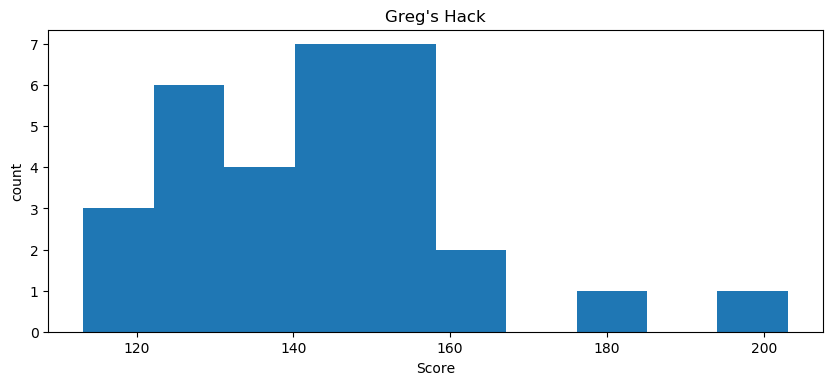

In [65]:
greg=pd.read_csv(data_dir+'greg.csv')
bob=list(greg)


fanduel_data=pd.DataFrame(index=range(len(greg)))
fanduel_data['data']=bob
fanduel_data['data']=fanduel_data['data'].astype(float)
plt.figure(figsize=(10,4),dpi=100)
plt.hist(fanduel_data.data,bins=10)
plt.title("Greg's Hack")
plt.ylabel('count')
plt.xlabel('Score')
plt.show()

'C:\\Users\\bill_\\Fantasy_Football_2019\\Fan_Duel\\data\\'

In [30]:
austin=pd.read_csv("C:\\Users\\bill_\\Fantasy_Football_2019\\FFootball_Data_Gathering_p2_7\\Data\\data_2009_present.csv",index_col=0)
austin=austin.loc[(austin.year==2019)&(austin.pos=='RB')&(austin.team=='LAC'),:]
austin.head(2)
del austin

In [80]:
tmp2="C:\\Users\\bill_\\Fantasy_Football_2019\\FFootball_Data_Gathering_p2_7\\Data\\"
tmp=pd.read_csv(tmp2+"data_2009_present.csv",index_col=0)
tmp=tmp.drop('Unnamed: 0.1',axis=1)

tmp.pivot_table(index='year',columns='week',values='receiving_tar',aggfunc='sum')

week,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
year,,,,,,,,,,,,,,,,,
2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
tmp.head(2)

,a_first_downs,a_passing_yds,a_penalty_cnt,a_penalty_yds,a_pos_time_tot_seconds,a_punt_avg,a_punt_cnt,a_punt_yds,a_rushing_yds,a_total_yds,a_turnovers,away,birthdate,day,defense_ast,defense_ffum,defense_fgblk,defense_frec,defense_frec_tds,defense_frec_yds,defense_int,defense_int_tds,defense_int_yds,defense_misc_tds,defense_misc_yds,defense_pass_def,defense_puntblk,defense_qbhit,defense_safe,defense_sk,defense_sk_yds,defense_tds,defense_tkl,defense_tkl_loss,defense_tkl_loss_yds,defense_tkl_primary,defense_xpblk,eid,first_down,first_name,fourth_down_att,fourth_down_conv,fourth_down_failed,fumbles_forced,fumbles_lost,fumbles_notforced,fumbles_oob,fumbles_rcv,fumbles_rec,fumbles_rec_tds,fumbles_rec_yds,fumbles_tot,fumbles_trcv,fumbles_yds,gamekey,h_first_downs,h_passing_yds,h_penalty_cnt,h_penalty_yds,h_pos_time_tot_seconds,h_punt_avg,h_punt_cnt,h_punt_yds,h_rushing_yds,h_total_yds,h_turnovers,height,home_x,home_y,id,kicking_all_yds,kicking_downed,kicking_fga,kicking_fgb,kicking_fgm,kicking_fgm_yds,kicking_fgmissed,kicking_fgmissed_yds,kicking_fgyds,kicking_i20,kicking_rec,kicking_rec_tds,kicking_tot,kicking_totpfg,kicking_touchback,kicking_xpa,kicking_xpb,kicking_xpmade,kicking_xpmissed,kicking_xptot,kicking_yds,kickret_avg,kickret_fair,kickret_lng,kickret_lngtd,kickret_oob,kickret_ret,kickret_tds,kickret_touchback,kickret_yds,last_name,loser,meridiem,month,name,passing_att,passing_cmp,passing_cmp_air_yds,passing_first_down,passing_incmp,passing_incmp_air_yds,passing_int,passing_ints,passing_sk,passing_sk_yds,passing_tds,passing_twopta,passing_twoptm,passing_twoptmissed,passing_yds,penalty,penalty_first_down,penalty_yds,playerid,pos,position,profile_id,punting_avg,punting_blk,punting_i20,punting_lng,punting_pts,punting_tot,punting_touchback,punting_yds,puntret_avg,puntret_downed,puntret_fair,puntret_lng,puntret_lngtd,puntret_oob,puntret_ret,puntret_tds,puntret_tot,puntret_touchback,puntret_yds,receiving_lng,receiving_lngtd,receiving_rec,receiving_tar,receiving_tds,receiving_twopta,receiving_twoptm,receiving_twoptmissed,receiving_yac_yds,receiving_yds,rushing_att,rushing_first_down,rushing_lng,rushing_lngtd,rushing_loss,rushing_tds,rushing_twopta,rushing_twoptm,rushing_twoptmissed,rushing_yds,score_away,score_away_q1,score_away_q2,score_away_q3,score_away_q4,score_away_q5,score_home,score_home_q1,score_home_q2,score_home_q3,score_home_q4,score_home_q5,scores,season_type,team,third_down_att,third_down_conv,third_down_failed,time,timeout,wday,week,weight,winner,xp_aborted,year,years_pro
0,18,234,5,28,1701,42,5,223,86,320,2,TEN,3/2/1982,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009091000,NaN,Ben,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54467,19,321,6,60,2171,41,7,299,36,357,3,77.0,yes,PIT,00-0022924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Roethlisberger,TEN,NaN,9,B.Roethlisberger,43.0,33.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1.0,0.0,0.0,NaN,363.0,NaN,NaN,NaN,00-0022924,QB,QB,2506109.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,3.0,NaN,NaN,0.0,0.0,0.0,NaN,3.0,10,0,7,0,3,0,13,0,7,0,3,3,[u'PIT - Q2 - TD - S.Holmes 34 yd. pass from B...,REG,PIT,NaN,NaN,NaN,8:30,NaN,Thu,1,240.0,PIT,NaN,2009,16.0
1,18,234,5,28,1701,42,5,223,86,320,2,TEN,6/19/1987,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009091000,NaN,Rashard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54467,19,321,6,60,2171,41,7,299,36,357,3,70.0,yes,PIT,00-0026163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mendenhall,TEN,NaN,9,R.Mendenhall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00-0026163,NaN,NaN,939.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [8]:
###########  No Longer Needed


tier_df=pd.DataFrame(columns=['Grade','Tier'],data=[['A+',1],['A',2],['A-',3],
                ['B+',4],['B',5],['B-',6],['C+',7],['C',8],['C-',9],
                ['D+',10],['D',11],['D-',12],['F',13]])

grades_file='player_grades'+str(week)+'.csv'
print('Reading {}'.format(grades_file))

player_grades=pd.read_csv(data_dir+grades_file,index_col=0).reset_index(drop=True)
player_grades=pd.merge(player_grades,tier_df,how='left',on='Grade')

player_grades.sort_values(['Tier','POS']).head(3)

Reading player_grades11.csv


,Player,Grade,POS,Tier
0,Christian McCaffrey,A+,RB,1
1,Ezekiel Elliott,A+,RB,1
2,Dalvin Cook,A+,RB,1
99,Travis Keice,A+,TE,1
100,Darren Waller,A+,TE,1
60,Michael Thomas,A+,WR,1
61,DeAndre Hopkins,A+,WR,1
34,Lamar Jackson,A,QB,2
35,Patrick Mahomes,A,QB,2
62,Julio Jones,A,WR,2


In [98]:
tmp=tmp.reset_index(drop=True)
tmp_dict={}
for i in tmp.index:
    b={}
    b[tmp['name'][i]]=tmp['team'][i]
    tmp_dict[tmp['eid'][i]]=b
    
tmp_dict

{2009091000: {'M.Griffin': 'TEN'},
 2009091300: {'C.Crowder': 'MIA'},
 2009091301: {'D.Johnson': 'KC'},
 2009091302: {'J.Hanson': 'PHI'},
 2009091303: {'E.Dumervil': 'DEN'},
 2009091304: {'J.Allen': 'MIN'},
 2009091305: {'L.Sheppard': 'NYJ'},
 2009091306: {'S.Considine': 'JAC'},
 2009091307: {'J.Dizon': 'DET'},
 2009091308: {'J.Ratliff': 'DAL'},
 2009091309: {'P.Haralson': 'SF'},
 2009091310: {'F.Smoot': 'WAS'},
 2009091311: {'R.Bartell': 'STL'},
 2009091312: {'N.Vasher': 'CHI'},
 2009091400: {'R.Corner': 'BUF'},
 2009091401: {'L.English': 'SD'},
 2009092000: {'D.Lewis': 'CAR'},
 2009092001: {'J.Allen': 'MIN'},
 2009092002: {'Dh.Jones': 'CIN'},
 2009092003: {'B.McFadden': 'ARI'},
 2009092004: {'G.Ellis': 'OAK'},
 2009092005: {'B.Meriweather': 'NE'},
 2009092006: {'J.Vilma': 'NO'},
 2009092007: {'A.Okoye': 'HOU'},
 2009092008: {'R.Bartell': 'STL'},
 2009092009: {'W.Allen': 'TB'},
 2009092010: {'C.Terrill': 'SEA'},
 2009092011: {'C.Hampton': 'PIT'},
 2009092012: {'C.Williams': 'CLE'},
 2

   Week  Bill  Greg  B_avg  G_avg  Bill_s  Greg_s
0     1     7     2    5.2    6.0  110.12  155.60
1     2     2     7    5.2    6.0  152.16  115.02


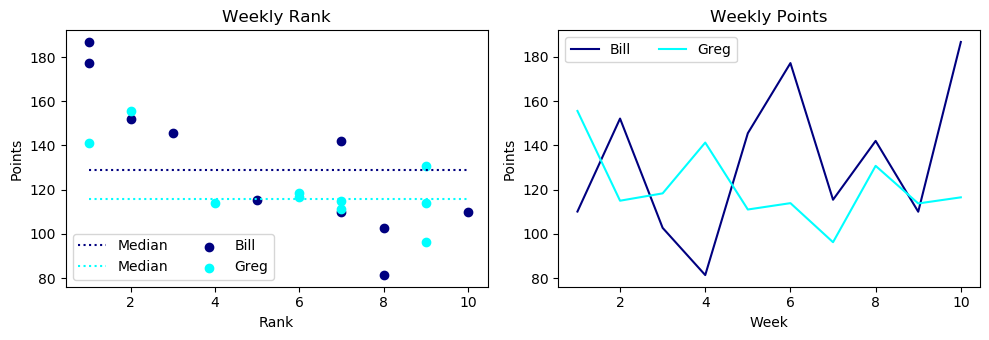

In [99]:
bob=pd.read_csv(data_dir+"GB_w10.csv")
plt.subplots(1,2,figsize=(10,3.5),dpi=100)

print(bob.head(2))
bill_med=bob.Bill_s.median()
greg_med=bob.Greg_s.median()

plt.subplot(1,2,1)
plt.scatter(bob.Bill,bob.Bill_s,color='navy',label='Bill')
plt.scatter(bob.Greg,bob.Greg_s,color='aqua',label='Greg')
plt.plot([1,10],[bill_med,bill_med],color='navy',label='Median',lineStyle=':')
plt.plot([1,10],[greg_med,greg_med],color='aqua',label='Median',lineStyle=':')
plt.legend(loc='lower left',ncol=2)
plt.xlabel('Rank')
plt.ylabel('Points')
plt.title('Weekly Rank')

plt.subplot(1,2,2)
plt.plot(bob.Week,bob.Bill_s,color='navy',label='Bill')
plt.plot(bob.Week,bob.Greg_s,color='aqua',label='Greg')
plt.legend(loc='upper left',ncol=2)
plt.xlabel('Week')
plt.ylabel('Points')
plt.title('Weekly Points')
plt.tight_layout()
plt.show()

In [103]:
df = pd.DataFrame(np.random.randint(0,100,size=(1000, 4)), columns=list('ABCD'))
print(df.shape)

def find_groupings_counts(ordered_breaks,the_array):
    '''ordered_breaks is a list of ordered percentiles to group array into, an example might be quartiles points
    for the reference data.
    the_array is the data ie: part level data for a sensor
    return list of counts that includes 0-first item and >last item'''
    old=0
    quarts=[]
    for i in ordered_breaks:
        tmp=the_array[(the_array>=old) &(the_array<i)]
        quarts.append(len(tmp))
        old=i
    quarts.append(len(the_array[the_array>=old]))
    return quarts

big_quarts=[]
ordered_breaks=[25,50,75]

cols=['q'+str(x+1) for x in range(len(df.columns))]
for c in df.columns:
    big_quarts.append(find_groupings_counts(ordered_breaks,df[c]))
    
new_df=pd.DataFrame(columns=cols, data=big_quarts)
new_df.T

(1000, 4)


,0,1,2,3
q1,256,240,245,245
q2,234,258,239,255
q3,246,231,259,282
q4,264,271,257,218


In [75]:
from sympy.interactive import printing
printing.init_printing(use_latex=True)

from sympy import *
import sympy as sp

x=sp.Symbol('x')

f=sp.Function('f')(x)
f

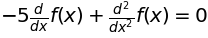

In [76]:
diffeq=Eq(f.diff(x,x)-5*f.diff(x),0)
display(diffeq)

In [77]:
dsolve(diffeq,f)

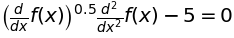

In [79]:
diffeq2=Eq(f.diff(x,x)*(f.diff(x)**0.5)-5,0)
display(diffeq2)
dsolve(diffeq2,f)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


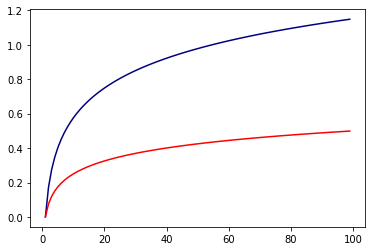

In [85]:
x=range(100)
plt.plot(x,np.log(x)/4,color='navy')
plt.plot(x,np.log10(x)/4,color='red')
plt.show()

## Assume that next week's FP is a function

func is average fp + log10(d func/dt)

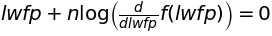

In [122]:
from sympy.functions.elementary.exponential import log as splog
x=sp.Symbol('lwfp')
f=sp.Function('f')(x)
n=sp.Symbol('n')
diffeq=Eq(x+n*splog(f.diff(x)))
display(diffeq)

dsolve(diffeq,f)

In [156]:
np.log(-4)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


In [161]:
import math
from scipy.optimize import curve_fit

def twfp(x,C1,n):
    new=C1-n*np.exp(0-x)/float(n)
    return new

    
fp_data=[10,8,13,15,11,7,12]
n=5
c1=20
for x in [10,8,13,15,11,7]:
    print(twfp(x,c1,n))
    
fit_params, pcov = curve_fit(twfp, [10,8,13,15,11,7],[8,13,15,11,7,12])
fit_params,pcov

19.999954600070236
19.999664537372098
19.999997739670594
19.999999694097678
19.99998329829921
19.999088118034447


(array([11.00021867,  1.        ]), array([[inf, inf],
        [inf, inf]]))

[12, 4.999569905135267, 4.936168262411184, 4.9765176160468245, 4.999941792989663]


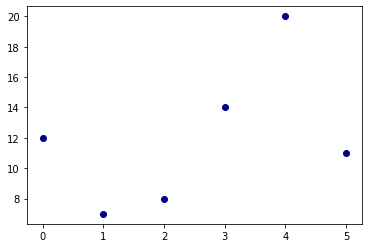

In [118]:
import math

lwfp=[12,7,8,14,20,11]
xs=range(len(lwfp))

n=70
c1=5
fp=lambda x: c1-n*math.exp(0-x)

pred=[lwfp[0]]+[fp(x) for x in lwfp[:-2]]
print(pred)


plt.scatter(xs,lwfp,color='navy')
plt.show()

In [112]:
fp=[x/math.exp(1) for x in lwfp]
fp

In [120]:
f=sp.Function('f')(x-1)
f

In [164]:
list(all_players.loc[all_players.name.str.contains('Brady'),'FP'])